In [1]:
%cd ..

/workspaces/Code


In [2]:
%matplotlib inline

from __future__ import annotations 

import numpy as np
import tensorflow as tf
import os
from IPython.display import display, HTML
import math
from PIL import Image
from io import BytesIO
import base64
from datetime import datetime
from image_provider import ImageProvider
from map_provider import MapProvider, ImageProjection
from vector import Vector2D
from ModelBuilders import MobileNetBuilder 
from tensorflow.keras import mixed_precision
from util import iterate_chunks
from itertools import product

from timer import Timer
import gc

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


def enable_gpu_memory_growth():
    """
    Enables memory growth mode for GPUs.
    """
    gpus = tf.config.experimental.list_physical_devices('GPU')
    assert len(gpus) > 0, "No GPUs detected!"
            
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

enable_gpu_memory_growth()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080, compute capability 7.5


2022-05-06 21:02:38.869202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:02:38.891464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:02:38.891639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:02:38.892275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
current_date = datetime.now().strftime("%Y-%m-%d.%H-%M-%S")
run_folder = f"Data/Embeddings/{current_date}"

## Run Config Data

In [6]:
base_size = 224
crop_scale = 3

crop_size = math.floor(base_size * crop_scale)
print(f"City crop size: {crop_size}")

graph_size = 1500
images_threshold = 0.7

step_size = 25

City crop size: 672


In [7]:
city_image = ImageProvider("City/NewCut/City_2017.jpg")
projection = ImageProjection(Vector2D(8000, 8000), Vector2D(6117, 5281))

## Setup Objects

In [8]:
city_map = MapProvider(
    image_provider=city_image,
    crop_size=crop_size,
    projection=projection)

In [9]:
model_builder = MobileNetBuilder(second_dense=8, weight_file="e1-s72-b1-rloss.h5")

## Run Data Dump/Save

In [10]:
def asBase64(image_np):
    image = Image.fromarray(image_np)
    
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode('ascii')

    return img_str

In [11]:
model = model_builder.create_model()

2022-05-06 21:02:54.610845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 21:02:54.611556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:02:54.611809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 21:02:54.612020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Experiment steps

In [12]:
def run():
    os.makedirs(run_folder, exist_ok=True)
    image_size = city_map.image_size
    x_range = range(0 + crop_size, image_size.x - crop_size, step_size)
    y_range = range(0 + crop_size, image_size.y - crop_size, step_size)

    particles = product(x_range, y_range)
    total = len(x_range) * len(y_range)
    print(f"Total: {total}")

    particle_embeddings = []
    print(f"{len(particle_embeddings)} / {total} -- {(len(particle_embeddings) / total) * 100}%")

    for chunk in iterate_chunks(particles, 5000):
        with Timer() as t:
            images = city_map.create_images_from_particles_threaded(chunk)

        print(f"\tCreated {len(images)} - {t.interval}")

        with Timer() as t:
            results = model.predict(np.array(images), batch_size=64)
            
        print(f"\tPredicted model - {t.interval}")

        particle_embeddings.extend(zip(chunk, results))
        # for particle, embedding in particle_embeddings: 
        #     file_name = f"{run_folder}/{particle}.npy"
        #     np.save(file_name, embedding, allow_pickle=True)

        print(f"{len(particle_embeddings)} / {total} -- {(len(particle_embeddings) / total) * 100:.2f}%")
        gc.collect()

    return particle_embeddings

In [13]:
particle_embeddings = run()

Total: 30178
0 / 30178 -- 0.0%
	Created 5000 - 0.40282630920410156


2022-05-06 21:02:56.715150: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


	Predicted model - 2.992527961730957
5000 / 30178 -- 16.57%
	Created 5000 - 0.3832995891571045
	Predicted model - 1.8299942016601562
10000 / 30178 -- 33.14%
	Created 5000 - 0.3850998878479004
	Predicted model - 1.8727235794067383
15000 / 30178 -- 49.71%
	Created 5000 - 0.39348435401916504
	Predicted model - 1.8430180549621582
20000 / 30178 -- 66.27%
	Created 5000 - 0.40592002868652344
	Predicted model - 1.8462913036346436
25000 / 30178 -- 82.84%
	Created 5000 - 0.39554858207702637
	Predicted model - 1.8356108665466309
30000 / 30178 -- 99.41%
	Created 178 - 0.024118900299072266
	Predicted model - 0.10020637512207031
30178 / 30178 -- 100.00%


In [14]:
drone_image = ImageProvider("City/NewCut/City_2016.jpg")
drone_map = MapProvider(
    image_provider=drone_image,
    crop_size=crop_size,
    projection=projection)

In [15]:
def dump_results(drone_position, top_images, top_weights):
    for chunked in iterate_chunks(zip(top_images, top_weights), 5):
        div = """<div class="row" style="display: flex">\n"""
        for image, top in chunked:
            particle, weight = top
            distance = Vector2D(particle[0], particle[1]).distance_to(drone_position)

            div += f"""
            <figure style="flex: 20%; height:245px; padding: 2px; margin: 2px">
                <img src=data:image/jpeg;base64,{asBase64(image)} style="height:224px; width:224px; padding: 0px"/>
                <figcaption>W: {weight:.4f}. D: {distance:.2f}. P: {particle}</figcaption>
            </figure>
            """

        div += "</div>"

        html = HTML(div)
        display(html)

In [16]:
relevant = 50 #px
top = 5
samples = 10

## Absolute difference
<img src="Images/DAbs.png" height="300">

0.0


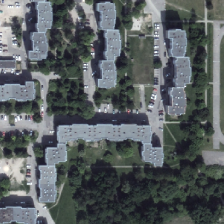

'(5582, 4441)'


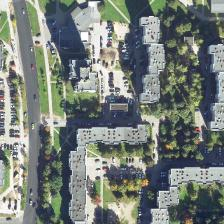
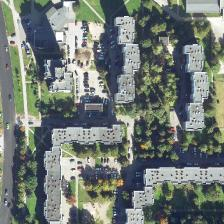
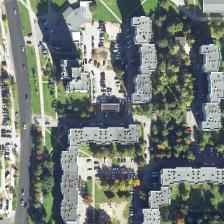
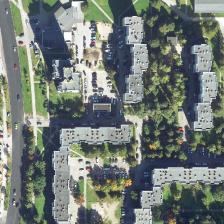
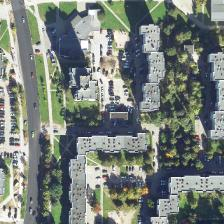


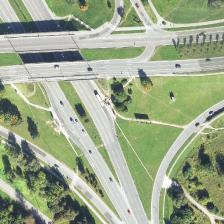
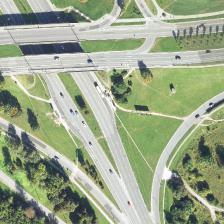
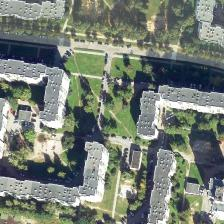
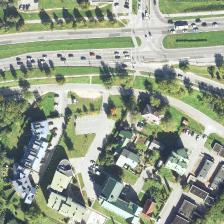
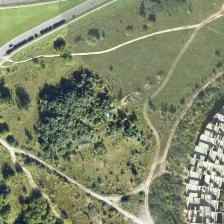

1.0


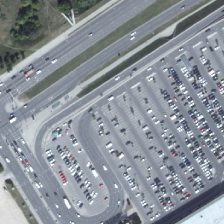

'(5302, 2341)'


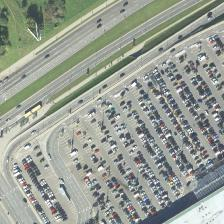
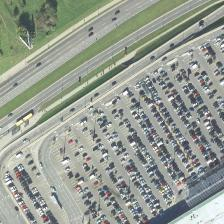
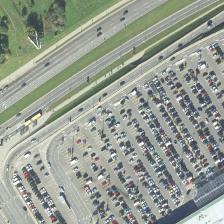
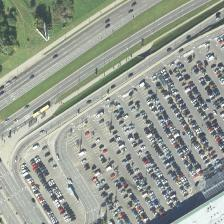
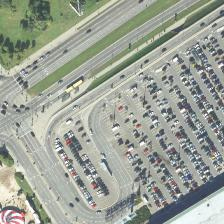


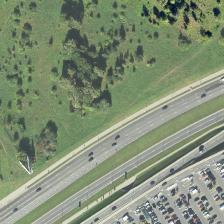
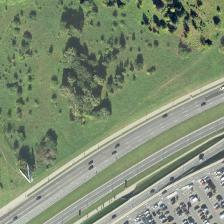
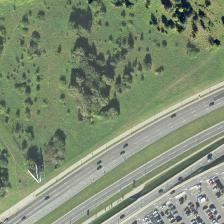
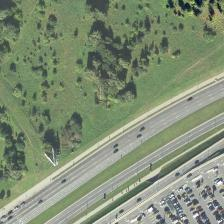
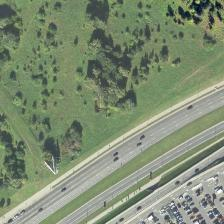

2.0


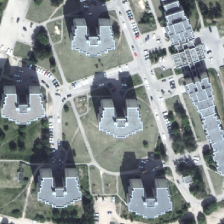

'(669, 1999)'


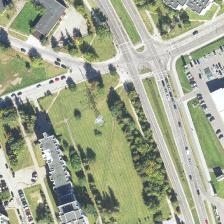
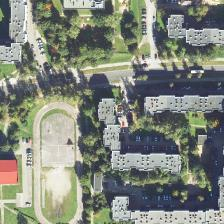
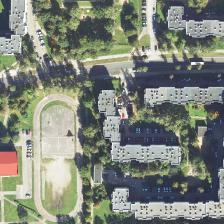
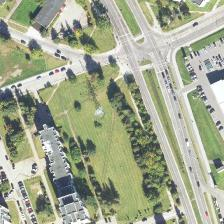
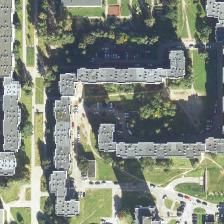


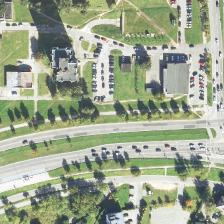
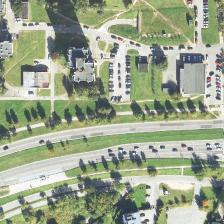
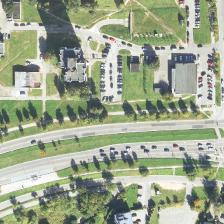
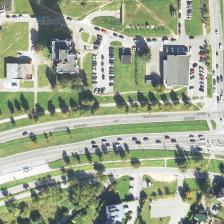
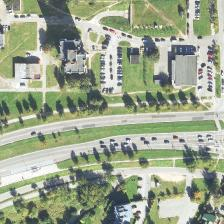

3.0


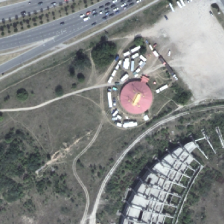

'(4684, 1814)'


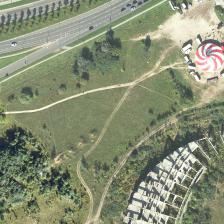
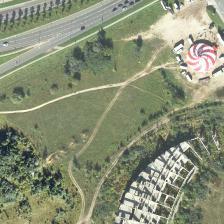
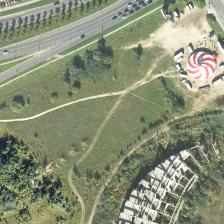
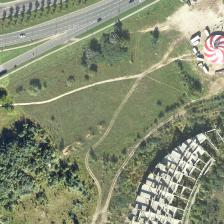
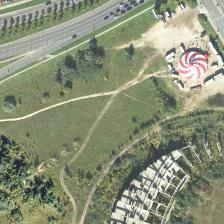


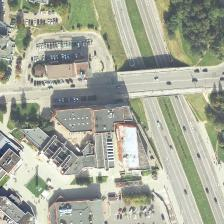
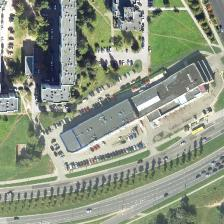
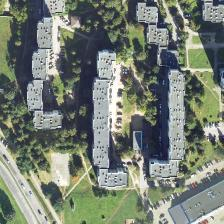
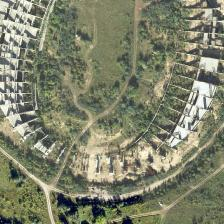
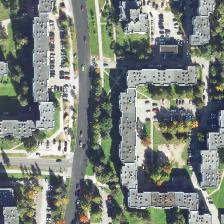

4.0


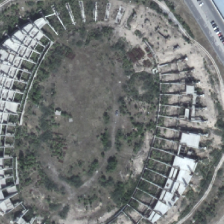

'(5134, 1442)'


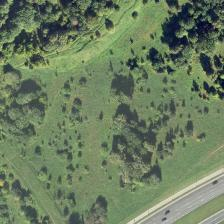
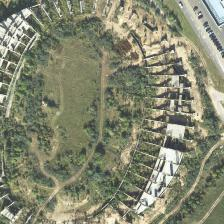
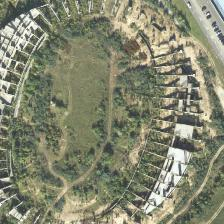
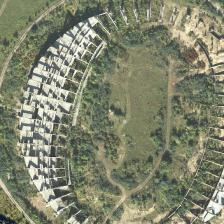
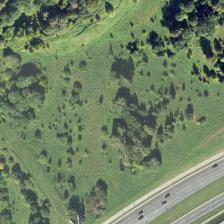


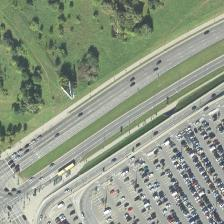
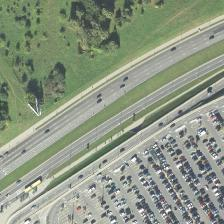
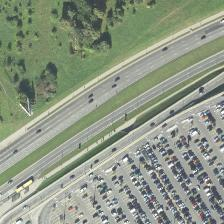
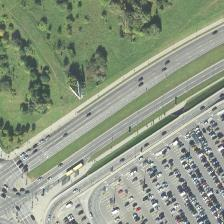
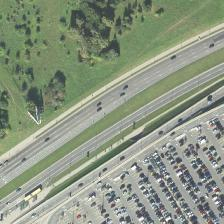

5.0


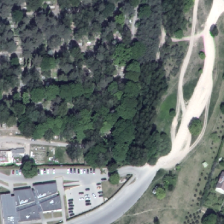

'(1249, 461)'


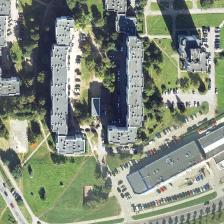
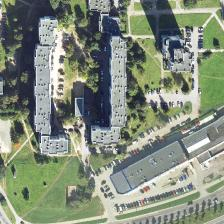
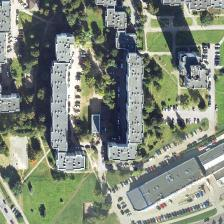
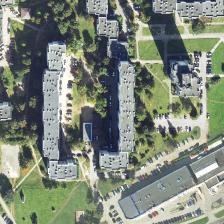
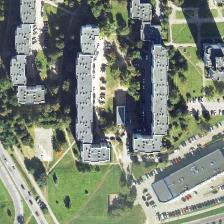


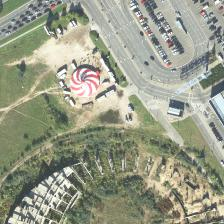
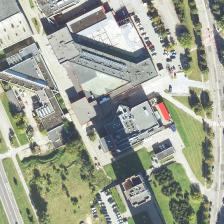
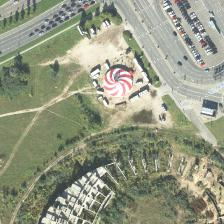
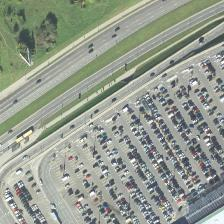
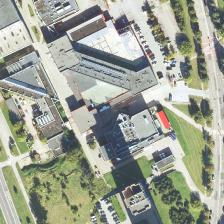

6.0


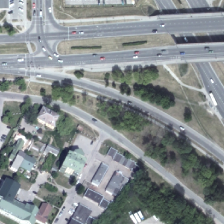

'(3414, 1789)'


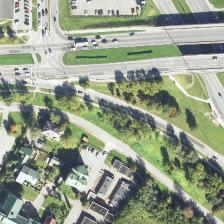
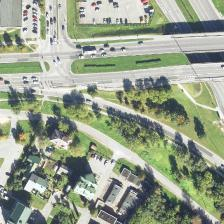
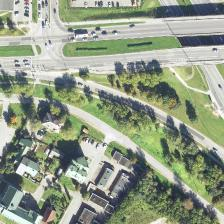
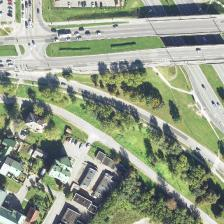
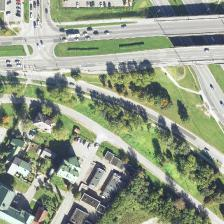


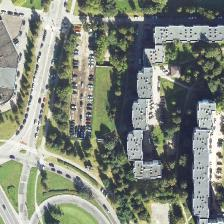
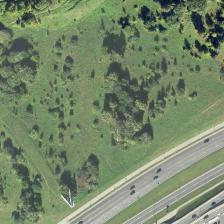
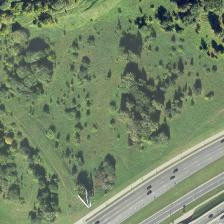
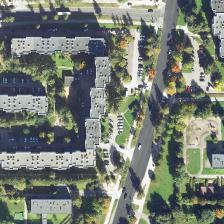
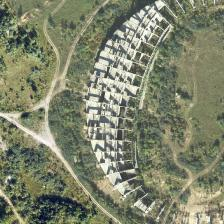

7.0


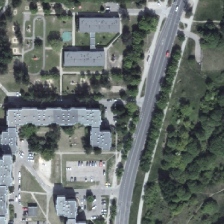

'(4678, 3403)'


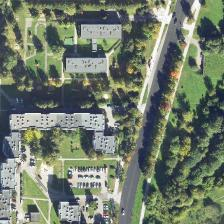
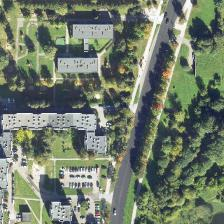
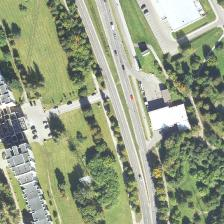
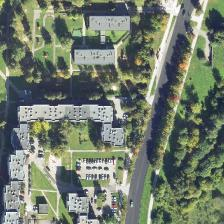
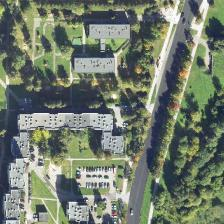


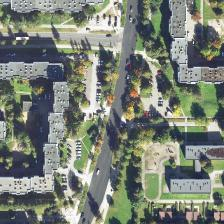
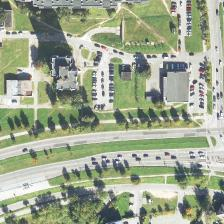
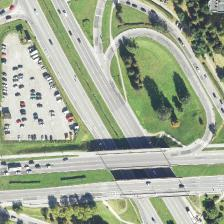
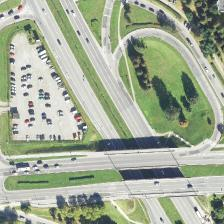
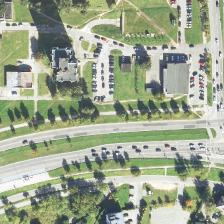

8.0


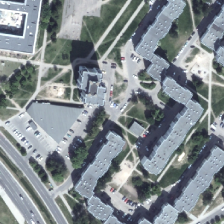

'(1158, 3276)'


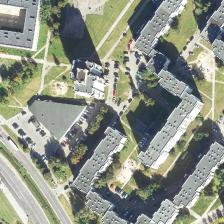
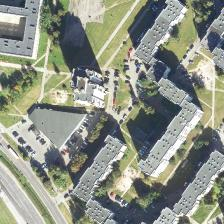
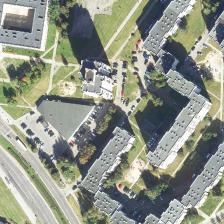
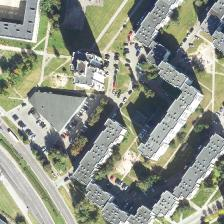
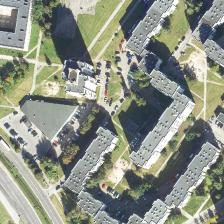


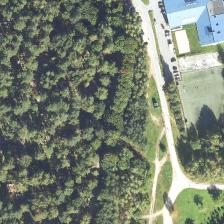
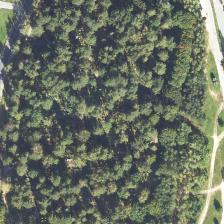
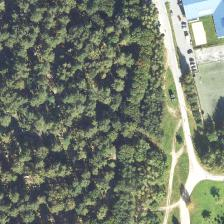
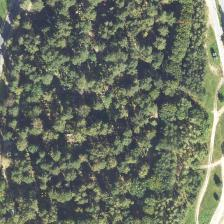
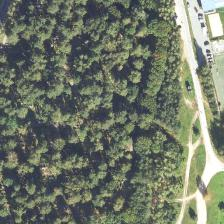

9.0


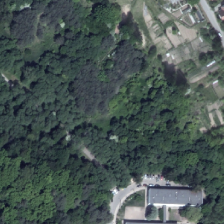

'(3223, 425)'


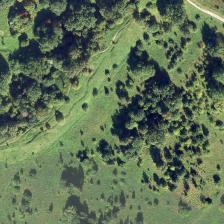
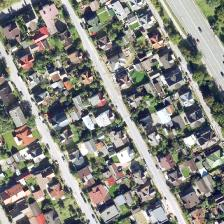
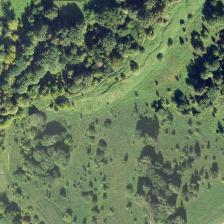
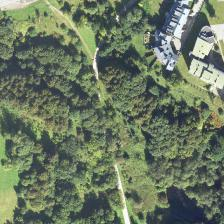
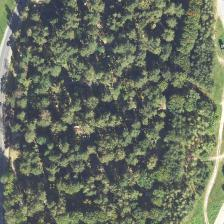


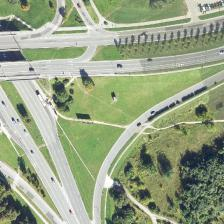
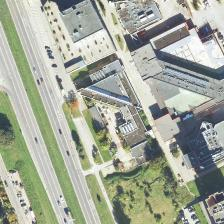
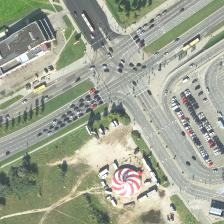
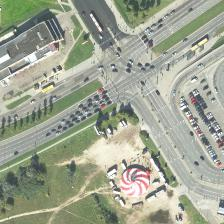
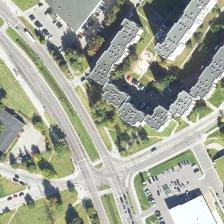

40.00%


In [17]:
def run():
    relevant_count = 0
    total_count = 0

    drone_locations = drone_map.generate_random_locations(samples)
    drone_images = drone_map.create_images_from_particles_threaded(drone_locations)
    drone_embeding = model.predict(np.array(drone_images), batch_size=64)

    for drone_location, drone_image, drone_embeding in zip(drone_locations, drone_images, drone_embeding):
        print(total_count / 5)

        x, y = drone_location

        particles = [particle for particle, _ in particle_embeddings]
        embeddings = [embedding for _, embedding in particle_embeddings]

        all_distances = np.abs(embeddings - drone_embeding)

        weights = []

        for particle, pair_distance in zip(particles, all_distances):
            distance = np.nansum(pair_distance)
            normalized_distance = 1 - (distance / (28 * 28 * 8)) # 1-similar, 0-different

            weights.append((particle, normalized_distance))

        def by_weight(w):
            return w[1]

        weights.sort(reverse=True, key=by_weight)

        drone_position = Vector2D(x, y)
        display(Image.fromarray(drone_image))
        display(f"{drone_position}")

        top_weights = weights[:top]

        top_particles = [particle for particle, _ in top_weights]
        top_images = city_map.create_images_from_particles_threaded(top_particles)

        for particle in top_particles:
            px, py = particle
            distance = Vector2D(px, py).distance_to(drone_position)

            if distance < relevant:
                relevant_count += 1
            
            total_count += 1

        dump_results(Vector2D(x, y), top_images, top_weights)

        bottom_weights = weights[-top:]

        bottom_particles = [particle for particle, _ in bottom_weights]
        bottom_images = city_map.create_images_from_particles_threaded(bottom_particles)

        dump_results(Vector2D(x, y), bottom_images, bottom_weights)
    
    print(f"{(relevant_count / total_count) * 100:.2f}%")

run()

## Difference squared
<img src="Images/DSquared.png" height="300">

0.0


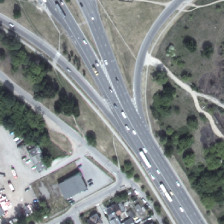

'(3926, 1479)'


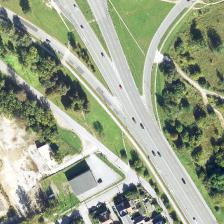
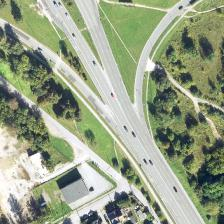
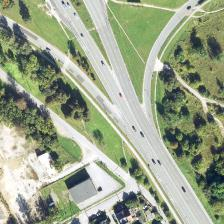
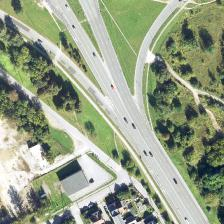
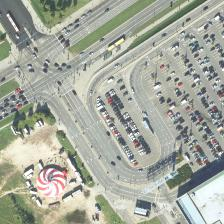


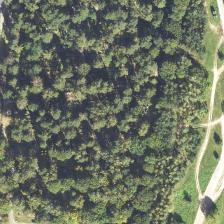
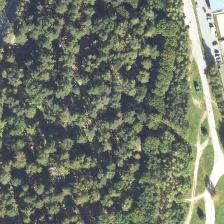
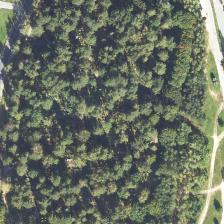
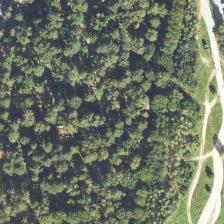
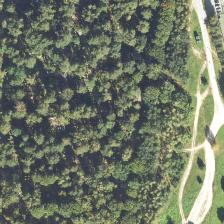

1.0


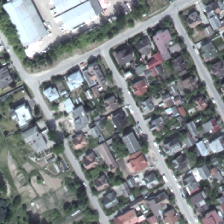

'(3629, 873)'


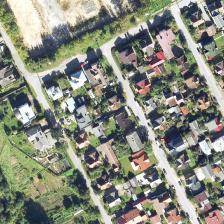
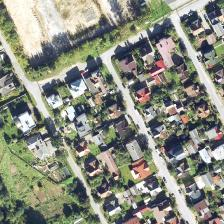
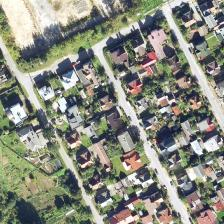
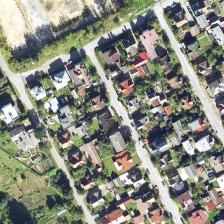
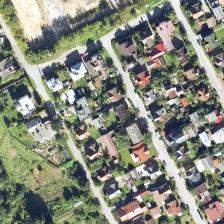


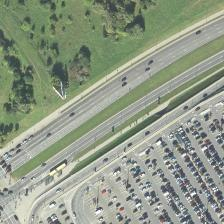
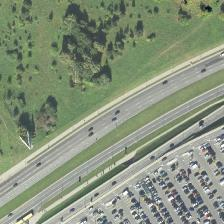
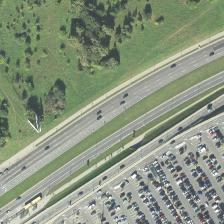
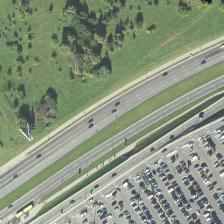
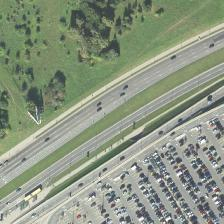

2.0


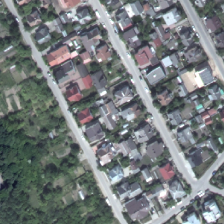

'(3831, 380)'


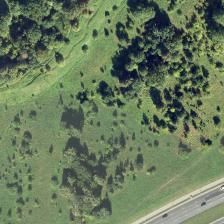
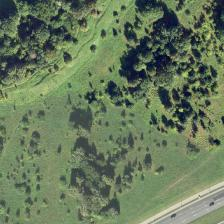
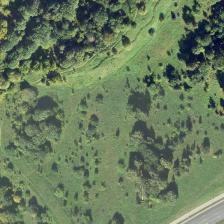
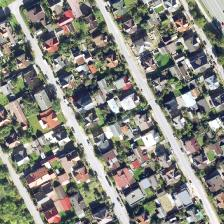
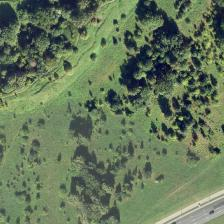


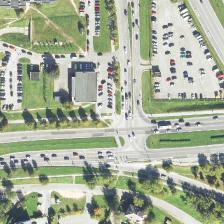
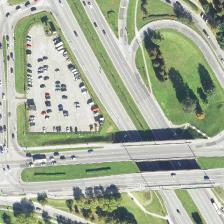
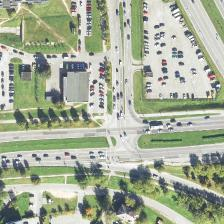
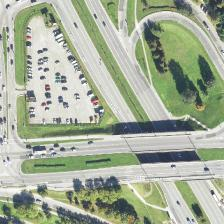
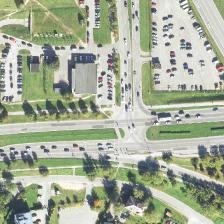

3.0


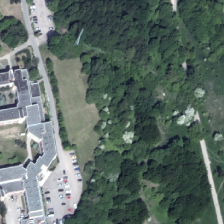

'(2437, 1178)'


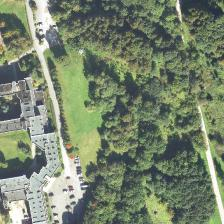
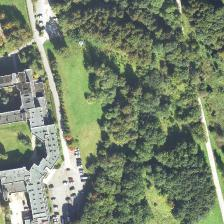
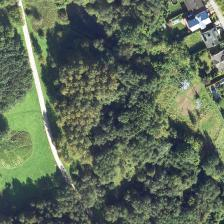
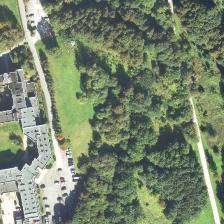
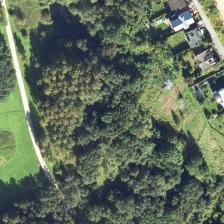


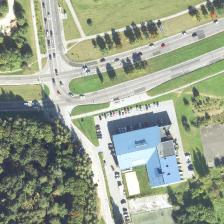
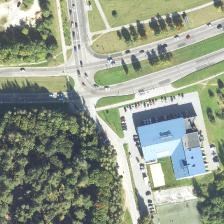
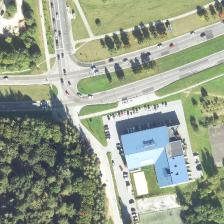
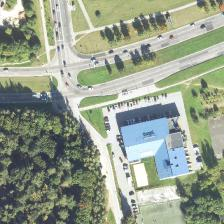
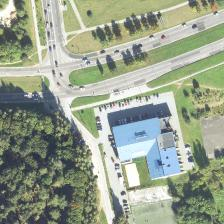

4.0


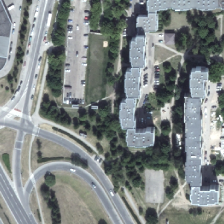

'(3840, 2597)'


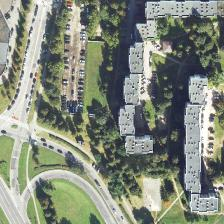
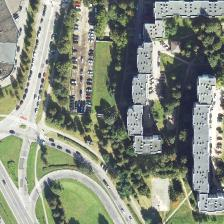
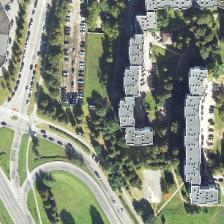
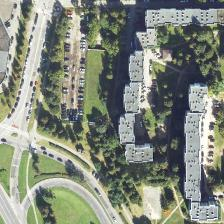
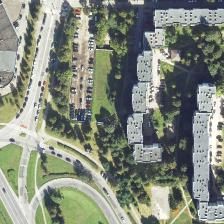


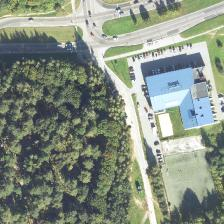
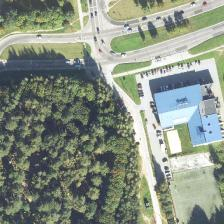
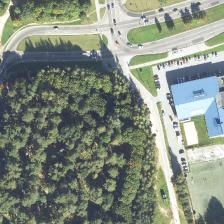
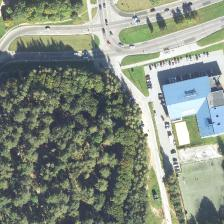
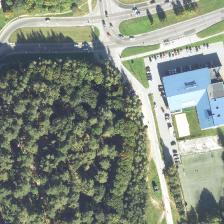

5.0


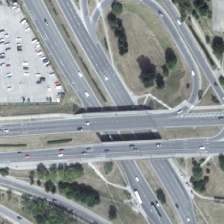

'(3639, 2083)'


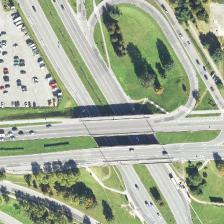
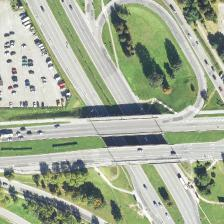
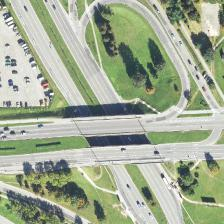
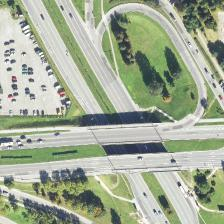
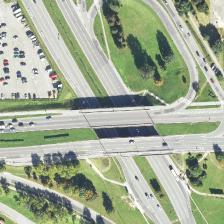


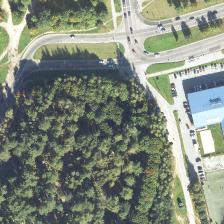
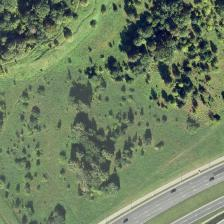
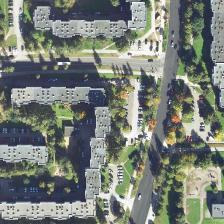
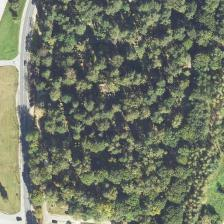
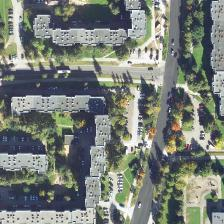

6.0


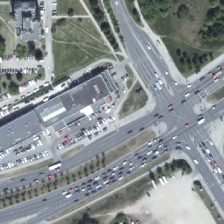

'(4737, 2345)'


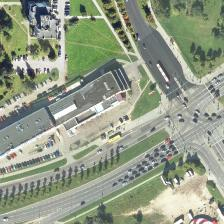
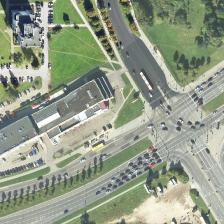
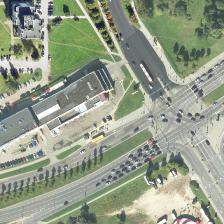
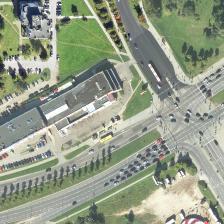
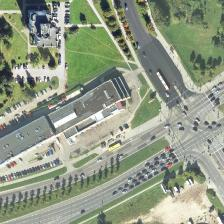


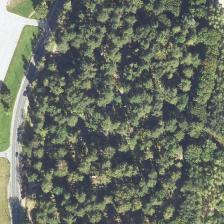
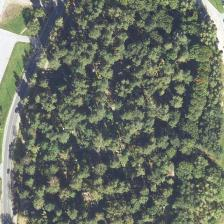
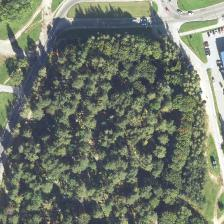
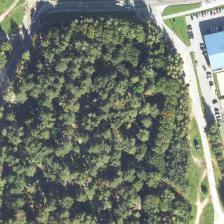
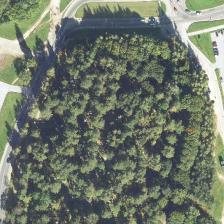

7.0


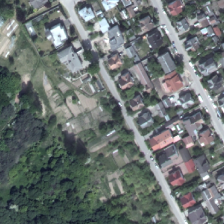

'(3523, 633)'


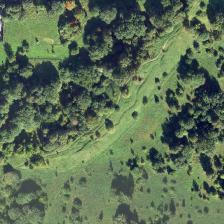
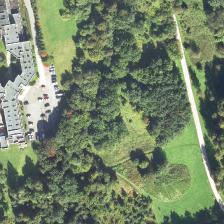
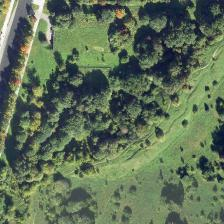
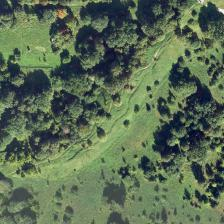
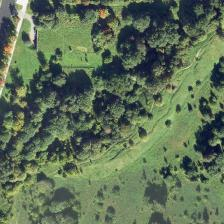


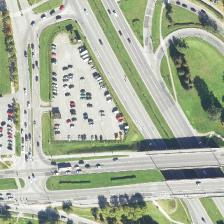
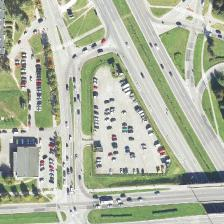
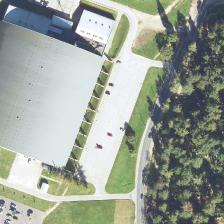
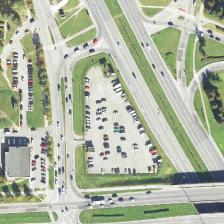
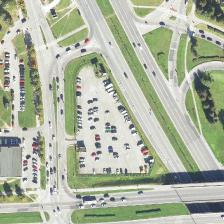

8.0


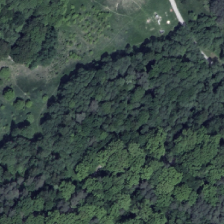

'(2625, 357)'


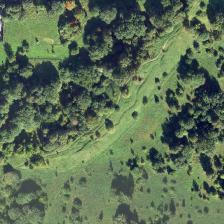
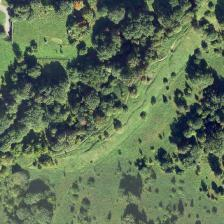
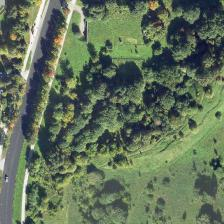
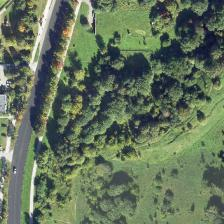
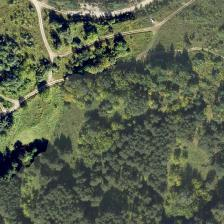


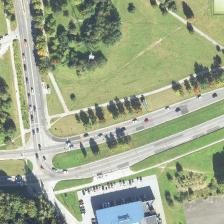
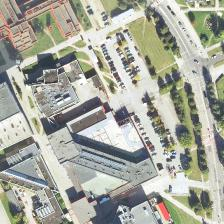
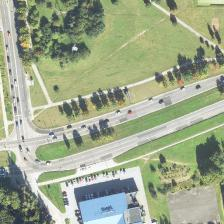
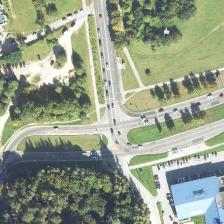
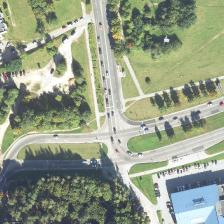

9.0


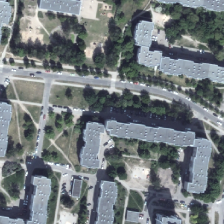

'(1530, 4352)'


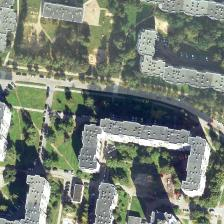
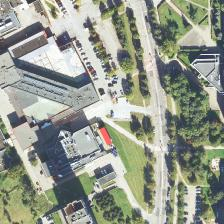
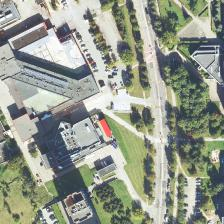
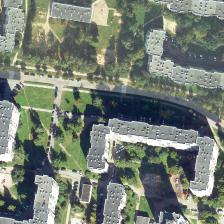
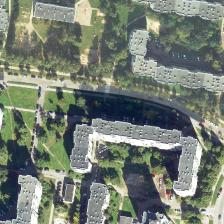


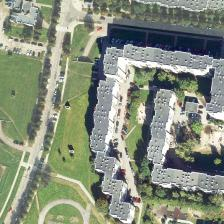
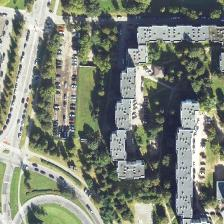
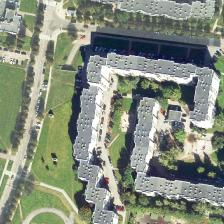
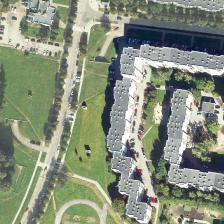
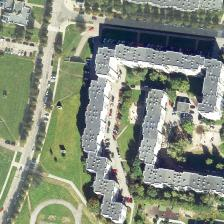

56.00%


In [18]:
def run():
    relevant_count = 0
    total_count = 0

    drone_locations = drone_map.generate_random_locations(samples)
    drone_images = drone_map.create_images_from_particles_threaded(drone_locations)
    drone_embeding = model.predict(np.array(drone_images), batch_size=64)

    for drone_location, drone_image, drone_embeding in zip(drone_locations, drone_images, drone_embeding):
        print(total_count / 5)

        x, y = drone_location

        particles = [particle for particle, _ in particle_embeddings]
        embeddings = [embedding for _, embedding in particle_embeddings]

        all_distances = np.square(embeddings - drone_embeding)

        weights = []

        for particle, pair_distance in zip(particles, all_distances):
            distance = np.nansum(pair_distance)
            normalized_distance = 1 - (distance / (28 * 28 * 8)) # 1-similar, 0-different

            weights.append((particle, normalized_distance))

        def by_weight(w):
            return w[1]

        weights.sort(reverse=True, key=by_weight)

        drone_position = Vector2D(x, y)
        display(Image.fromarray(drone_image))
        display(f"{drone_position}")

        top_weights = weights[:top]

        top_particles = [particle for particle, _ in top_weights]
        top_images = city_map.create_images_from_particles_threaded(top_particles)

        for particle in top_particles:
            px, py = particle
            distance = Vector2D(px, py).distance_to(drone_position)

            if distance < relevant:
                relevant_count += 1
            
            total_count += 1

        dump_results(Vector2D(x, y), top_images, top_weights)

        bottom_weights = weights[-top:]

        bottom_particles = [particle for particle, _ in bottom_weights]
        bottom_images = city_map.create_images_from_particles_threaded(bottom_particles)

        dump_results(Vector2D(x, y), bottom_images, bottom_weights)
    
    print(f"{(relevant_count / total_count) * 100:.2f}%")

run()